In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

/Users/lipengyuan/anaconda3/envs/py3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lipengyuan/anaconda3/envs/py3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lipengyuan/anaconda3/envs/py3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lipeng

2.3.0


In [58]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    plt.grid(False)
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [97]:
import pandas as pd
data = pd.read_csv('tst.csv')
time = data.date[1:].to_numpy(dtype = object)
series = data.sales[1:].to_numpy(dtype = float)

split_time = 666
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7
batch_size = 7
shuffle_buffer_size = 30


In [72]:
# type(time.to_numpy(dtype = object))

In [76]:
len(time), len(series), len(time_train),len(time_valid)

(934, 934, 666, 268)

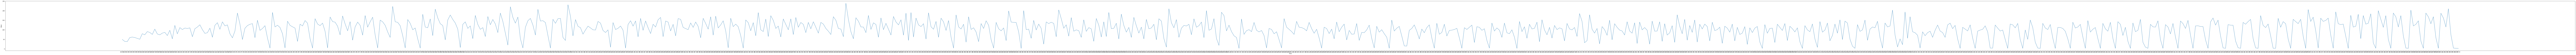

In [51]:

    
# plot_series(time[:100], series[:100])

plt.figure(figsize=(400,8))
plot_series(time, series)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## DNN :
3 layer DNN

In [87]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(88, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=50,verbose=0)

In [88]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

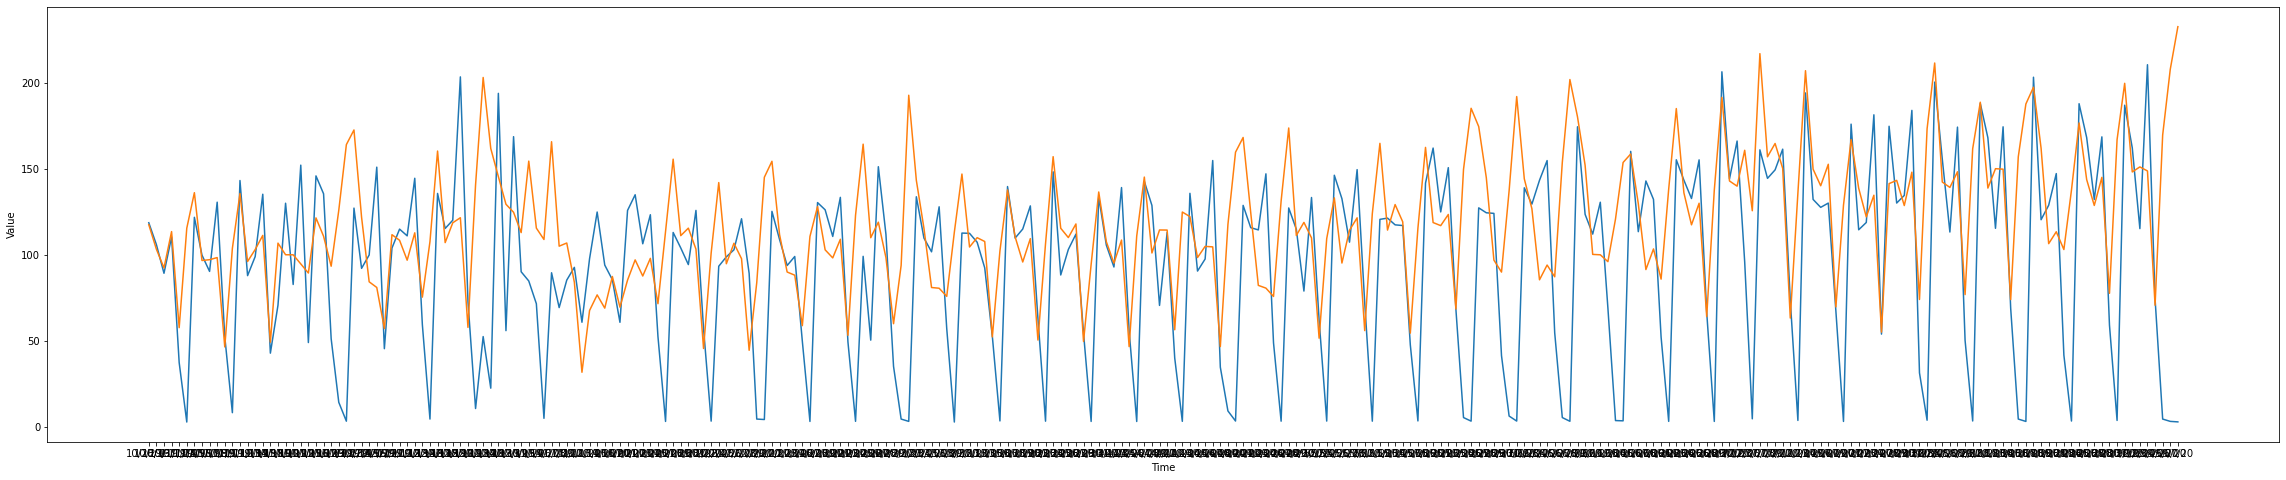

In [89]:
plt.figure(figsize=(40, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [90]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# 45 43

43.65793

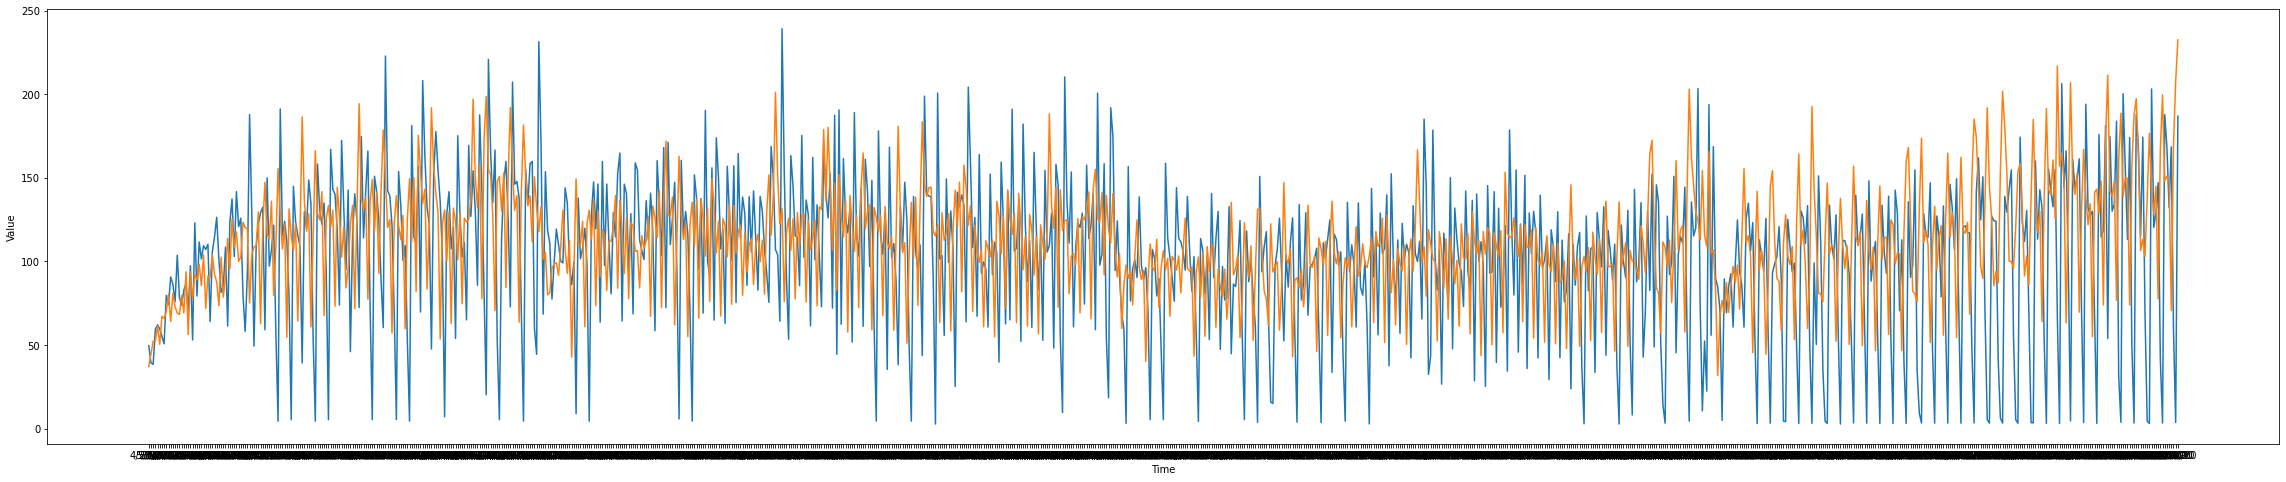

In [98]:
#ploting on whole dataset 
forecast = []
for t in range(len(series) - window_size):
    forecast.append(model.predict(series[t:t + window_size][np.newaxis]))

# forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(40, 8))
plot_series(time[0:len(results)], series[0:len(results)])
plot_series(time[0:len(results)], results)

In [102]:
len(series)

934

In [107]:
t=927
model.predict(series[t:t + window_size][np.newaxis])
# series[time:time + window_size][np.newaxis]

array([[175.44403]], dtype=float32)